## Image网 Submission `128x128`

This contains a submission for the Image网 leaderboard in the `128x128` category.

In this notebook we:
1. Train on 1 pretext task: 
  - Train a network to do image inpatining on Image网's `/train`, `/unsup` and `/val` images. 
2. Train on 4 downstream tasks:
  - We load the pretext weights and train for `5` epochs.
  - We load the pretext weights and train for `20` epochs.
  - We load the pretext weights and train for `80` epochs.
  - We load the pretext weights and train for `200` epochs.
  
Our leaderboard submissions are the accuracies we get on each of the downstream tasks.

In [1]:
import json
import torch

import numpy as np

from functools import partial

from fastai2.layers import Mish, MaxPool, LabelSmoothingCrossEntropy
from fastai2.learner import Learner
from fastai2.metrics import accuracy, top_k_accuracy
from fastai2.basics import DataBlock, RandomSplitter, GrandparentSplitter, CategoryBlock

from fastai2.optimizer import ranger, Adam, SGD, RMSProp

from fastai2.vision.all import *
from fastai2.vision.core import *
from fastai2.vision.augment import *
from fastai2.vision.learner import unet_learner, unet_config
from fastai2.vision.models.xresnet import xresnet50, xresnet34

from fastai2.data.transforms import Normalize, parent_label
from fastai2.data.external import download_url, URLs, untar_data


from fastcore.utils import num_cpus

from torch.nn import MSELoss
from torchvision.models import resnet34

## Pretext Task: Image Inpainting

In [2]:

# def _cutout(x, n_holes:uniform_int=1, length:uniform_int=40):
#     "Cut out `n_holes` number of square holes of size `length` in image at random locations."
#     h,w = x.shape[1:]
#     for n in range(n_holes):
#         h_y = np.random.randint(0, h)
#         h_x = np.random.randint(0, w)
#         y1 = int(np.clip(h_y - length / 2, 0, h))
#         y2 = int(np.clip(h_y + length / 2, 0, h))
#         x1 = int(np.clip(h_x - length / 2, 0, w))
#         x2 = int(np.clip(h_x + length / 2, 0, w))
#         x[:, y1:y2, x1:x2] = 0
#     return x

# cutout = TfmPixel(_cutout, order=20)

In [3]:
# Default parameters
gpu=None
lr=1e-2
size=128
sqrmom=0.99
mom=0.9
eps=1e-6
epochs=15
bs=64
mixup=0.
opt='ranger',
arch='xresnet50'
sh=0.
sa=0
sym=0
beta=0.
act_fn='Mish'
fp16=0
pool='AvgPool',
dump=0
runs=1
meta=''

In [4]:
# Chosen parameters
lr=8e-3
sqrmom=0.99
mom=0.95
eps=1e-6
bs=64 
opt='ranger'
sa=1
fp16=1               #NOTE: My GPU cannot run fp16 :'(
arch='xresnet50' 
pool='MaxPool'

gpu=0

# NOTE: Normally loaded from their corresponding string
m = xresnet34
act_fn = Mish
pool = MaxPool

In [5]:
# class RandomCutout(RandTransform):
class RandomCutout(ItemTransform):
    "Picks a random scaled crop of an image and resize it to `size`"
    split_idx = None
    order = 11
    def __init__(self, min_n_holes=10, max_n_holes=20, min_length=5, max_length=30, **kwargs):
        super().__init__(**kwargs)
        self.min_n_holes=min_n_holes
        self.max_n_holes=max_n_holes
        self.min_length=min_length
        self.max_length=max_length
#         self.patch_tfms = Pipeline([Dihedral(0.9), Brightness(), Contrast()], split_idx=0)
        self.patch_tfms = Pipeline([Dihedral(0.9)], split_idx=0)
#         self.patch_tfms.split_idx=1

    def encodes(self, xy):
        """
        Note that we're accepting our dummy PILImageInput class
        fastai2 will only pass images of this type to our encoder. 
        This means that our transform will only be applied to input images and won't
        be run against output images.
        """
        x,y = xy
#         if x isinstance(OutputTensorImage): return None
        n_holes = np.random.randint(self.min_n_holes, self.max_n_holes)
#         pixels = np.array(x) # Convert to mutable numpy array. FeelsBadMan
        bs,ch,h,w = x.shape

        for n in range(n_holes):
            h_length = np.random.randint(self.min_length, self.max_length)
            w_length = np.random.randint(self.min_length, self.max_length)
            h_y = np.random.randint(0, h)
            h_x = np.random.randint(0, w)
            y1 = int(np.clip(h_y - h_length / 2, 0, h))
            y2 = int(np.clip(h_y + h_length / 2, 0, h))
            x1 = int(np.clip(h_x - w_length / 2, 0, w))
            x2 = int(np.clip(h_x + w_length / 2, 0, w))
           
            patch = x[..., y1:y2, x1:x2]
            
            x[..., y1:y2, x1:x2] = self.patch_tfms(TensorImage(patch))
#             x[..., y1:y2, x1:x2] = 0
            
        return TensorImage(x), TensorImage(y)

In [6]:
# def get_dbunch(size, bs, workers=8):
#     path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
#     source = untar_data(path)
    
#     files = get_image_files(source)
#     tfms = [[PILImage.create, ToTensor, Resize(size)], 
#             [PILImage.create, ToTensor, Resize(size)]]
    
#     dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
#     batch_tfms = [IntToFloatTensor, FlipItem(0.5), RandomCutout, Normalize.from_stats(*imagenet_stats)]
#     dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
#     dls.path = source
#     return dls

In [7]:
def get_dbunch(size, bs, sh=0., workers=None):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
        
    item_tfms=[ToTensor, RandomResizedCrop(size, min_scale=0.35)]
    batch_tfms = [IntToFloatTensor, FlipItem(0.5), RandomCutout, Normalize.from_stats(*imagenet_stats)]
    
    dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                       splitter=RandomSplitter(0.1),
                       get_items=get_image_files, 
                       get_y=lambda o: o,
                      item_tfms=item_tfms,
                      batch_tfms=batch_tfms)
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=workers)

In [8]:
# Use the Ranger optimizer
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [9]:
size = 128
bs = 64

dbunch = get_dbunch(size, bs)
#CHANGE: We're predicting pixel values, so we're just going to predict an output for each RGB channel
dbunch.vocab = ['R', 'G', 'B']

/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/site-packages/torch/nn/functional.py:2751: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
/home/ashaw/anaconda3/envs/rsna_retro/lib/python3.7/site-packages/torch/nn/functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "


In [10]:
len(dbunch.train.dataset), len(dbunch.valid.dataset)

(23714, 2634)

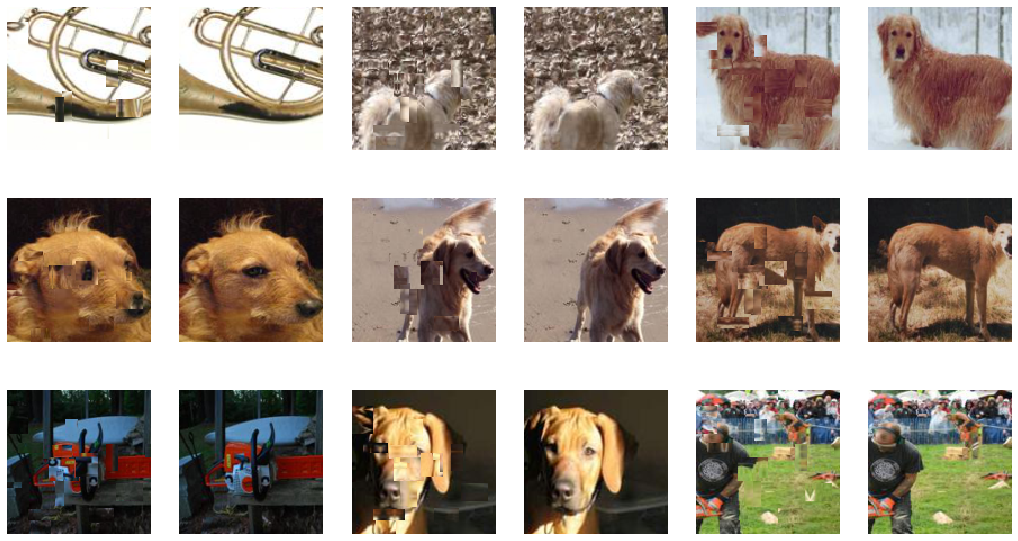

In [11]:
dbunch.show_batch()

In [12]:
xb,yb = dbunch.one_batch()

In [13]:
learn = unet_learner(dbunch, partial(m, sa=sa), pretrained=False, opt_func=opt_func, metrics=[], loss_func=MSELoss()).to_fp16()
cbs = MixUp(mixup) if mixup else []
learn.fit_flat_cos(30, lr, wd=1e-2, cbs=cbs)




epoch,train_loss,valid_loss,time
0,0.087417,0.084112,01:45
1,0.052431,0.054070,01:42
2,0.048373,0.040106,01:44
3,0.037292,0.045359,01:54
4,0.034936,0.041836,01:43
5,0.034080,0.042692,01:43
6,0.033894,0.035489,01:41
7,0.032178,0.035002,01:42
8,0.031368,0.034224,01:41
9,0.029916,0.036454,01:44


In [14]:
# I'm not using fastai2's .export() because I only want to save 
# the model's parameters. 
torch.save(learn.model[0].state_dict(), 'imagewang_inpainting_15_epochs_flip.pth')

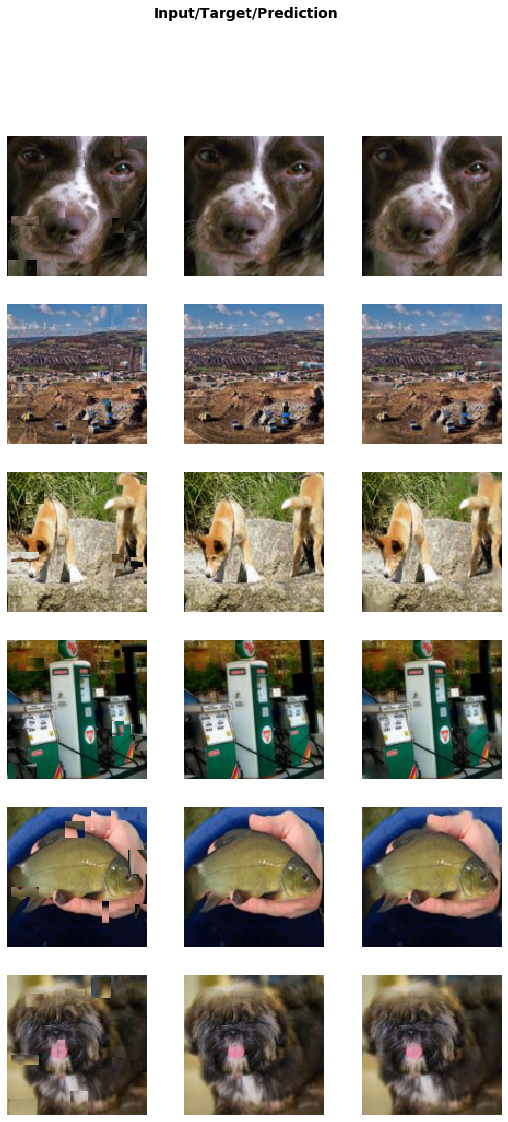

In [15]:
learn.show_results()

## Downstream Task: Image Classification

In [16]:
def get_dbunch(size, bs, sh=0., workers=None):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
#     batch_tfms=RandomErasing(p=0.9, max_count=3, sh=sh) if sh else None
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, get_y=parent_label,
                      item_tfms=item_tfms, batch_tfms=batch_tfms)
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=workers,
                             )#item_tfms=item_tfms, batch_tfms=batch_tfms)

In [17]:
dbunch = get_dbunch(size, bs, sh=sh)

In [18]:
m_part = partial(m, c_out=20, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool)

### 5 Epochs

In [19]:
epochs = 5
runs = 5

In [20]:
for run in range(runs):
        print(f'Run: {run}')
                        
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func, pretrained=False,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy(),
                config={'custom_head':ch})
        
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
            
#         # Load weights generated from training on our pretext task
        state_dict = torch.load('imagewang_inpainting_15_epochs_flip.pth')
        learn.model[0].load_state_dict(state_dict)
        
        learn.unfreeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.625365,3.498035,0.049631,0.519980,00:26
1,1.418651,3.052789,0.123187,0.660219,00:28
2,1.318333,2.626949,0.197506,0.720540,00:27
3,1.234223,2.773682,0.202342,0.660473,00:27
4,1.089292,2.229224,0.354034,0.824128,00:26


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.649733,3.159289,0.028760,0.440061,00:25
1,1.424754,3.001332,0.143293,0.607025,00:26
2,1.331865,2.498948,0.229575,0.732247,00:27
3,1.241594,2.366059,0.288623,0.763553,00:26
4,1.097465,2.272810,0.337999,0.819292,00:26


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.636027,2.981321,0.058285,0.530669,00:25
1,1.457947,2.527558,0.210995,0.728175,00:27
2,1.311504,2.606947,0.197760,0.723085,00:26
3,1.233591,2.987205,0.153474,0.605498,00:27
4,1.096534,2.256199,0.339527,0.821074,00:30


Run: 3


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.649550,4.038563,0.004836,0.352507,00:26
1,1.453971,3.365317,0.077373,0.465513,00:27
2,1.310773,2.706220,0.208195,0.654110,00:26
3,1.246106,2.924695,0.133622,0.681598,00:27
4,1.080708,2.307904,0.315856,0.815729,00:26


Run: 4


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.635110,3.258899,0.020107,0.470603,00:26
1,1.447593,3.152499,0.114278,0.518962,00:27
2,1.340325,2.780584,0.172308,0.635022,00:27
3,1.240686,2.788335,0.185034,0.651311,00:27
4,1.095103,2.234475,0.345126,0.828455,00:26


* Run 1: 0.362942
* Run 2: 0.372868
* Run 3: 0.342326
* Run 4: 0.360143
* Run 5: 0.357088

Accuracy: **35.91%**

### 20 Epochs

In [21]:
epochs = 20
runs = 3

In [22]:
for run in range(runs):
        print(f'Run: {run}')
                        
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func, pretrained=False,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy(),
                config={'custom_head':ch})
        
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
            
#         # Load weights generated from training on our pretext task
        state_dict = torch.load('imagewang_inpainting_15_epochs_flip.pth')
        learn.model[0].load_state_dict(state_dict)
        
        learn.unfreeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.657547,3.025239,0.055230,0.557903,00:26
1,1.435866,2.730876,0.162382,0.636294,00:28
2,1.323853,2.589447,0.207686,0.680071,00:27
3,1.245350,2.639770,0.221430,0.719776,00:27
4,1.200333,2.464137,0.252482,0.769661,00:27
5,1.136603,2.938861,0.178417,0.663782,00:27
6,1.099015,2.479828,0.275388,0.746500,00:27
7,1.091981,2.158170,0.397302,0.809621,00:27
8,1.046188,1.992216,0.436498,0.871978,00:27
9,1.009011,2.195662,0.402392,0.828201,00:27


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.653727,3.778576,0.008145,0.274370,00:26
1,1.439487,2.898742,0.114533,0.611351,00:27
2,1.324413,3.026559,0.110206,0.573428,00:26
3,1.247937,2.636482,0.201833,0.743192,00:27
4,1.197706,2.321780,0.317129,0.791805,00:26
5,1.131530,2.854470,0.162382,0.754645,00:27
6,1.080886,2.140161,0.397811,0.867142,00:27
7,1.061578,2.221136,0.363960,0.829728,00:27
8,1.043940,2.076380,0.420972,0.845253,00:27
9,1.016530,2.328725,0.367014,0.820565,00:26


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.625601,3.235882,0.025706,0.454060,00:26
1,1.432110,2.990279,0.117078,0.552558,00:27
2,1.334146,2.865107,0.189361,0.741410,00:32
3,1.262200,2.442574,0.286332,0.735556,00:28
4,1.180006,2.518407,0.286587,0.744464,00:27
5,1.141345,2.886658,0.160092,0.681598,00:27
6,1.101104,2.487243,0.293204,0.743955,00:27
7,1.058801,2.263729,0.364978,0.804276,00:27
8,1.047565,2.130773,0.400865,0.843217,00:26
9,1.017182,2.118389,0.406719,0.857725,00:27


* Run 1: 0.592263
* Run 2: 0.588445
* Run 3: 0.595571

Accuracy: **59.21%**

## 80 epochs

In [12]:
epochs = 80
runs = 1

In [13]:
for run in range(runs):
        print(f'Run: {run}')
                        
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func, pretrained=False,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy(),
                config={'custom_head':ch})
        
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
            
#         # Load weights generated from training on our pretext task
        state_dict = torch.load('imagewang_inpainting_15_epochs_nopretrain.pth')
        learn.model[0].load_state_dict(state_dict)
        
        learn.unfreeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.627083,3.367977,0.074319,0.434462,00:28
1,1.432624,2.835915,0.142275,0.626368,00:28
2,1.315572,3.173710,0.120641,0.544159,00:28
3,1.262181,2.628366,0.261135,0.678544,00:28
4,1.196247,2.715817,0.261390,0.669891,00:28
5,1.151967,2.244764,0.347162,0.819292,00:28
6,1.106040,2.542930,0.274879,0.716976,00:28
7,1.081001,2.435337,0.328328,0.785951,00:28
8,1.040587,2.182454,0.385085,0.829728,00:28
9,1.021549,2.127460,0.426826,0.851107,00:28


Accuracy: **61.44%**

### 200 epochs

In [20]:
epochs = 200
runs = 1

In [15]:
for run in range(runs):
        print(f'Run: {run}')
                        
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func, pretrained=False,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy(),
                config={'custom_head':ch})
        
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
            
#         # Load weights generated from training on our pretext task
        state_dict = torch.load('imagewang_inpainting_15_epochs_nopretrain.pth')
        learn.model[0].load_state_dict(state_dict)
        
        learn.unfreeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.637033,3.049698,0.082973,0.497837,00:36
1,1.419114,2.515247,0.219394,0.753118,00:36
2,1.309143,2.553103,0.237210,0.733011,00:36
3,1.246102,2.507335,0.238738,0.722321,00:36
4,1.160114,2.534244,0.261390,0.770171,00:38
5,1.146491,2.416984,0.315602,0.751082,00:36
6,1.098252,2.374685,0.332909,0.767625,00:37
7,1.054157,2.649198,0.296004,0.697887,00:36
8,1.034104,2.182474,0.402138,0.821074,00:36
9,1.001304,2.034533,0.457877,0.848562,00:36


Accuracy: **59.18%**